In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

In [5]:
precip = pd.read_table("data/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30


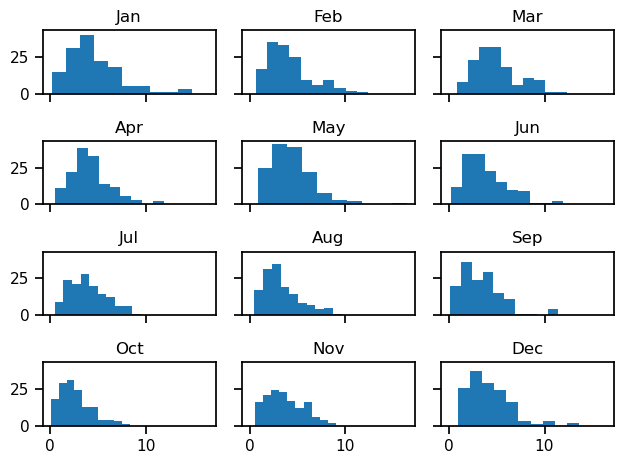

In [6]:
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

In [7]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)
precip

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30
...,...,...,...,...,...,...,...,...,...,...,...,...
2007,3.32,1.84,2.26,2.75,3.30,2.37,1.47,1.38,1.99,4.95,6.20,3.83
2008,4.76,2.53,5.56,7.20,5.54,2.21,4.32,1.67,0.88,5.03,1.75,6.72
2009,4.59,2.85,2.92,4.13,8.45,4.53,6.03,2.14,11.08,6.49,0.67,3.99


In [8]:
precip_mean = precip.mean()
precip_mean

Jan    4.523688
Feb    4.097801
Mar    4.977589
Apr    4.204468
May    4.325674
Jun    3.873475
Jul    3.895461
Aug    3.367305
Sep    3.377660
Oct    2.610500
Nov    3.685887
Dec    4.176241
dtype: float64

In [9]:
precip_var = precip.var()
precip_var

Jan    6.928862
Feb    5.516660
Mar    5.365444
Apr    4.117096
May    5.306409
Jun    5.033206
Jul    3.777012
Aug    3.779876
Sep    4.940099
Oct    2.741659
Nov    3.679274
Dec    5.418022
dtype: float64

In [10]:
precip.Apr

Year
1871     4.13
1872     5.91
1873     3.59
1874    11.84
1875     4.22
        ...  
2007     2.75
2008     7.20
2009     4.13
2010     3.48
2011     7.51
Name: Apr, Length: 141, dtype: float64

<Axes: >

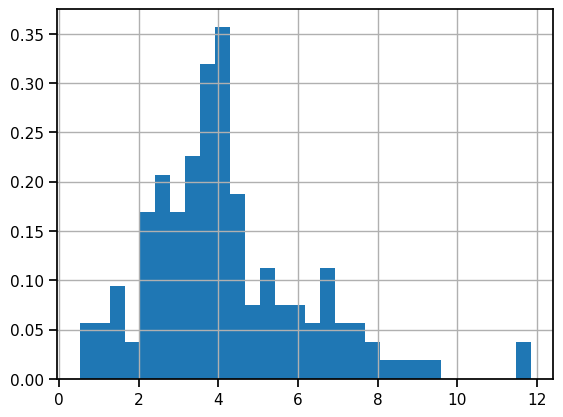

In [18]:
precip.Apr.hist(density=True, bins=30)

In [19]:
from pymc import Model, Uniform, Gamma, summary

with Model() as rainfall_model:
    ualpha = Uniform('ualpha', lower=0, upper=15)
    ubeta = Uniform('ubeta', lower=0, upper=15)

with rainfall_model:
    april_like = Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)

In [20]:
from pymc import fit

with rainfall_model:
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 369.28


array([<Axes: title={'center': 'ualpha'}>,
       <Axes: title={'center': 'ubeta'}>], dtype=object)

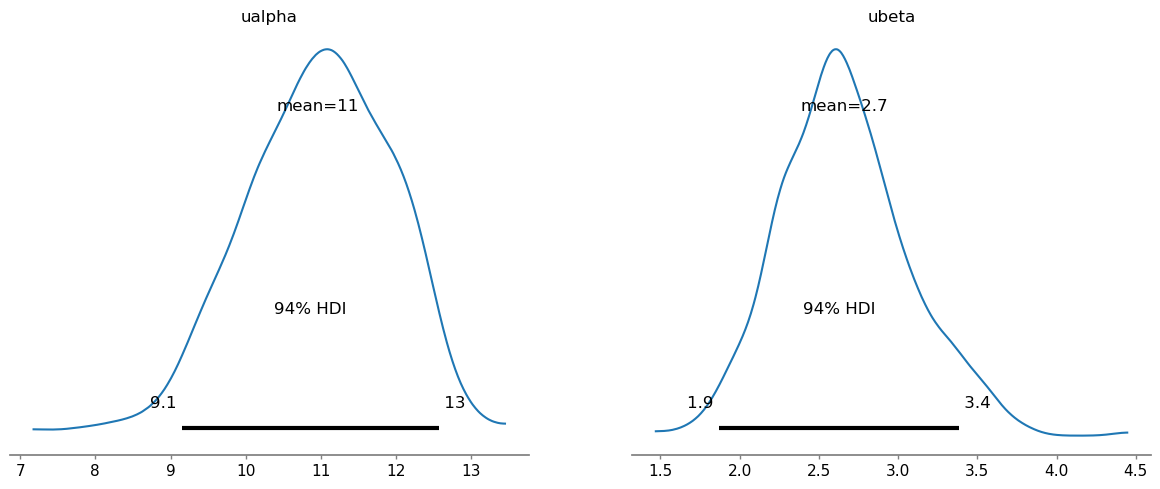

In [21]:
import arviz as az

# Assuming you have already run the fitting code and have rainfall_trace as an InferenceData object
burn_in = 100  # Adjust this value based on your burn-in period

# Extract trace
burned_trace = rainfall_trace.posterior["ualpha"].values[:, burn_in:]

# Plot the posterior distributions
az.plot_posterior(data=rainfall_trace, var_names=['ualpha', 'ubeta'])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


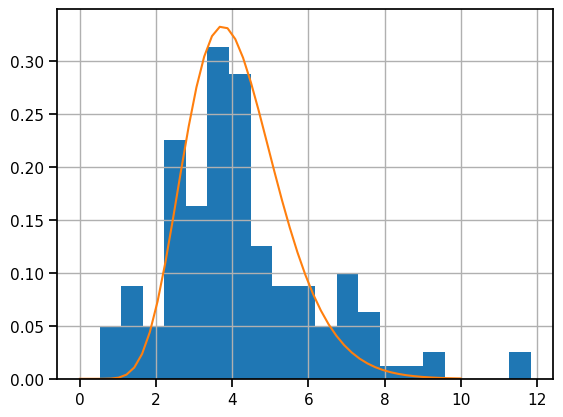

In [22]:
from scipy.stats.distributions import gamma

ualpha_posterior_mean = summary(rainfall_trace)['mean']['ualpha']
ubeta_posterior_mean = summary(rainfall_trace)['mean']['ubeta']

precip.Apr.hist(density=True, bins=20)
plt.plot(np.linspace(0, 10), gamma.pdf(np.linspace(0, 10), a = ualpha_posterior_mean, scale = 1/ubeta_posterior_mean))

# Part 2: Modelling all months

In [23]:
from pymc import Model, Uniform, Gamma, summary
from pymc import fit
import arviz as az
from scipy.stats.distributions import gamma

# Define the hierarchical model for all months
with Model() as rainfall_model:
    ualpha = Uniform('ualpha', lower=0, upper=15)
    ubeta = Uniform('ubeta', lower=0, upper=15)
    for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        month_like = Gamma(month + '_like', alpha=ualpha, beta=ubeta, observed=precip[month])

# Perform MCMC sampling to fit the model for all months
with rainfall_model:
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

# Simulate rainfall data for all months
simulated_rainfall = {}
for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
    ualpha_posterior_mean = summary(rainfall_trace)['mean']['ualpha']
    ubeta_posterior_mean = summary(rainfall_trace)['mean']['ubeta']
    simulated_rainfall[month] = gamma.rvs(ualpha_posterior_mean, scale=1 / ubeta_posterior_mean, size=len(precip[month]))

Finished [100%]: Average Loss = 5,053.4
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed:

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


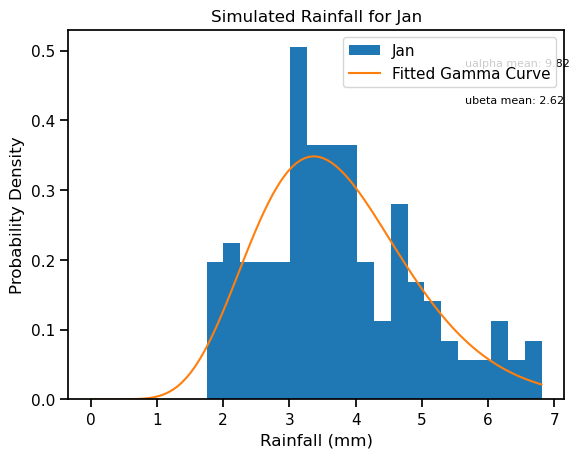

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


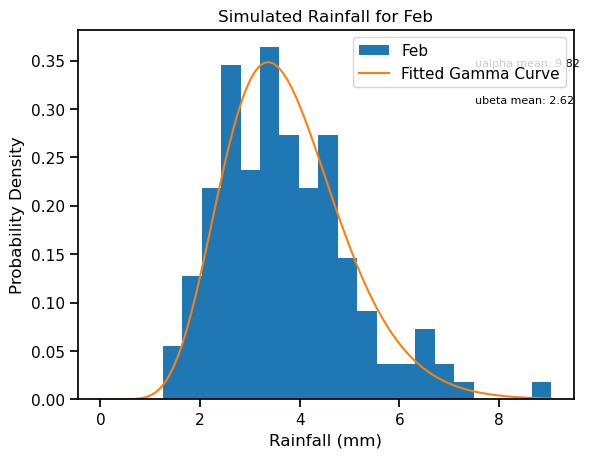

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


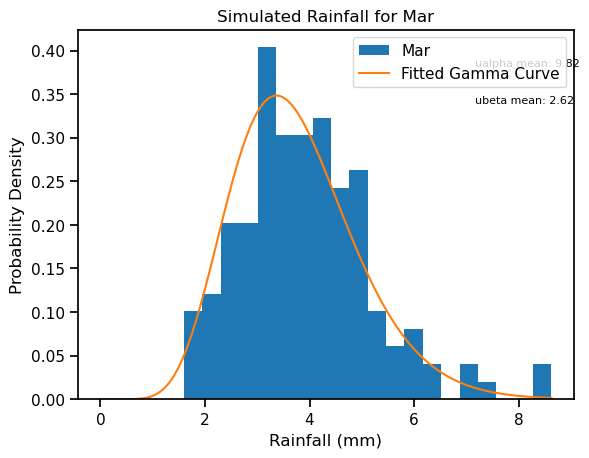

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


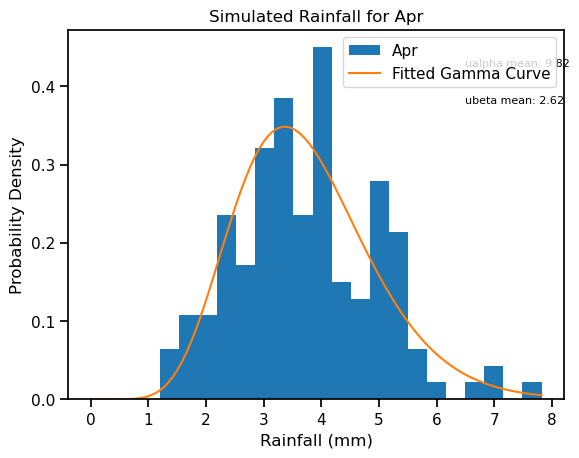

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


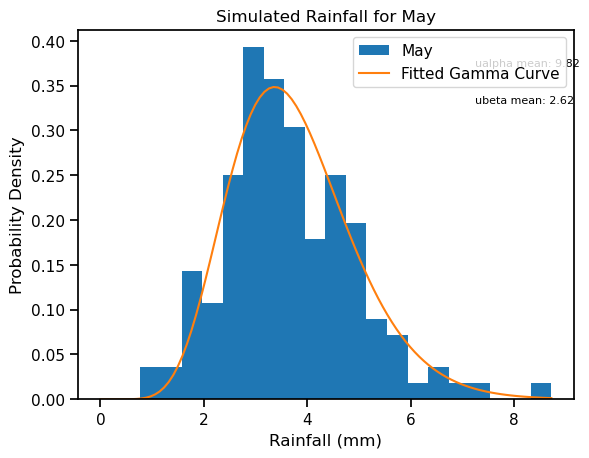

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


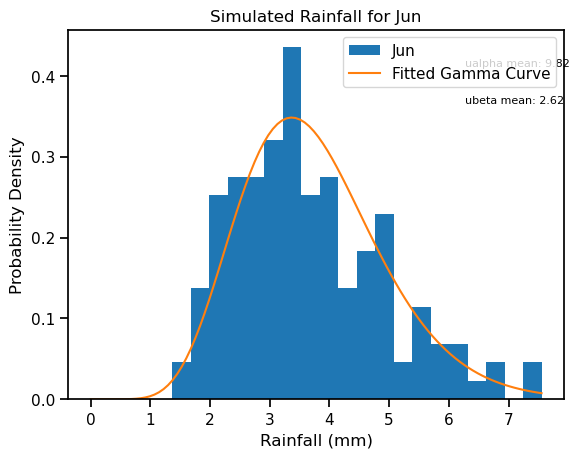

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


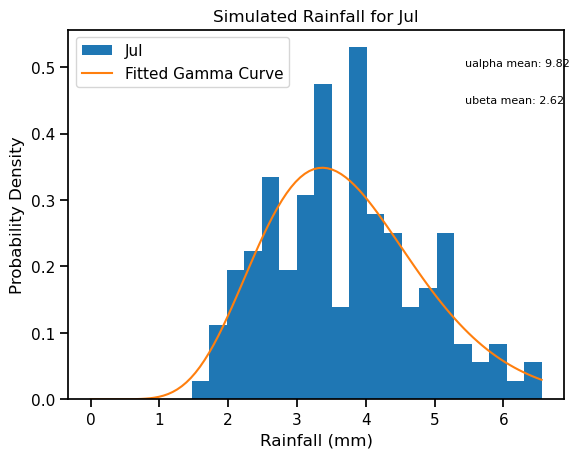

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


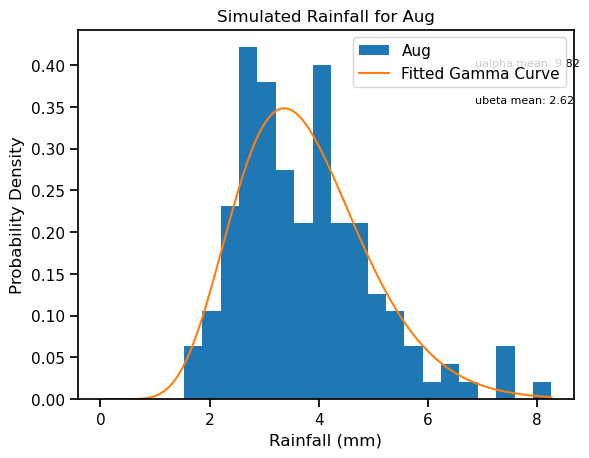

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


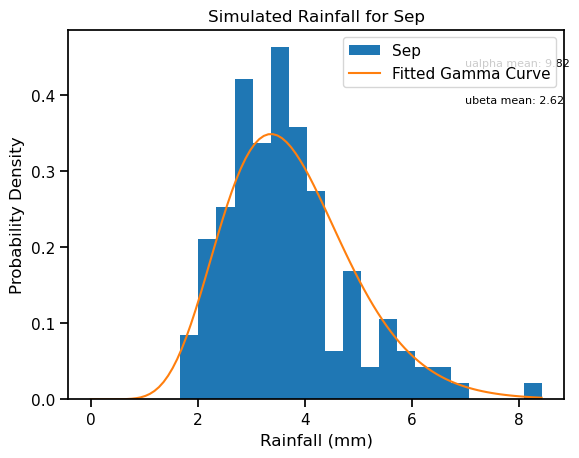

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


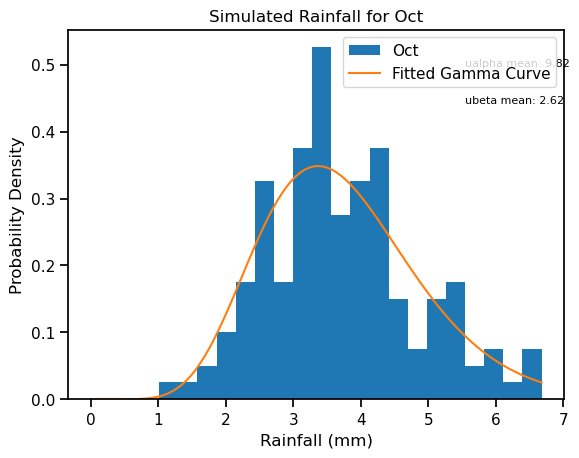

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


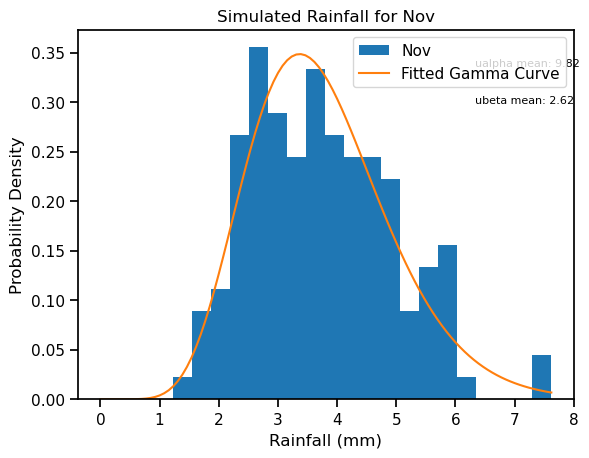

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


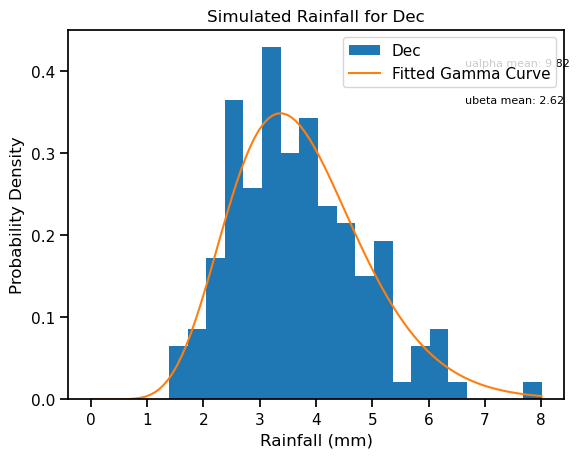

In [24]:
from scipy.stats.distributions import gamma

import matplotlib.pyplot as plt
# Create separate histograms and display ualpha and ubeta means

for month, simulated_data in simulated_rainfall.items():

    plt.figure()

    plt.hist(simulated_data, bins=20, label=month, density=True)
    # Extract posterior means for ualpha and ubeta

    ualpha_posterior_mean = summary(rainfall_trace)['mean']['ualpha']

    ubeta_posterior_mean = summary(rainfall_trace)['mean']['ubeta']
    # Calculate x-values for the fitted Gamma distribution curve

    x_values = np.linspace(0, max(simulated_data), 100)
    # Calculate y-values for the fitted Gamma distribution curve

    y_values = gamma.pdf(x_values, ualpha_posterior_mean, scale=1 / ubeta_posterior_mean)
    # Plot the fitted Gamma distribution curve

    plt.plot(x_values, y_values, label='Fitted Gamma Curve')
    plt.title('Simulated Rainfall for ' + month)

    plt.xlabel('Rainfall (mm)')

    plt.ylabel('Probability Density')
    # Display ualpha and ubeta means on the plot

    plt.annotate(f"ualpha mean: {ualpha_posterior_mean:.2f}", xy=(0.8, 0.9), xycoords='axes fraction', fontsize=8)

    plt.annotate(f"ubeta mean: {ubeta_posterior_mean:.2f}", xy=(0.8, 0.8), xycoords='axes fraction', fontsize=8)
    plt.legend()

    plt.show()